# GMRQ Figure
Make a split box-and-whisker plot with tICA lagtimes (split by featurizer) on the x-axis and their corresponding GMRQ distributions along the y-axis

In [1]:
# Suppress warnings for clarity
import warnings
warnings.filterwarnings('ignore')

#### Load FS-peptide Trajectories

In [2]:
from glob import glob
import mdtraj as md

top = md.load("../fs-peptide.pdb")
trajs = [md.load(i, top=top, stride=10) for i in glob('../Trajectories/trajectory-*.xtc')]

/home/cxh/miniconda/envs/notebook/lib/python2.7/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


#### Set up SciKit-Learn `Pipline` and Perform Cross-Validation

In [3]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.pipeline import Pipeline

from msmbuilder.feature_selection import FeatureSelector
from msmbuilder.featurizer import DihedralFeaturizer, ContactFeaturizer
from msmbuilder.decomposition import tICA
from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.msm import MarkovStateModel

features = FeatureSelector([
        ('Dihedrals', DihedralFeaturizer(types=['phi', 'psi'], sincos=True)),
        ('Contacts', ContactFeaturizer(scheme='ca')),
    ])
pipeline = Pipeline([
        ('featurizer', features),
        ('tica', tICA(n_components=2)),
        ('cluster', MiniBatchKMeans(n_clusters=250)),
        ('msm', MarkovStateModel(n_timescales=3))
    ])
ss = ShuffleSplit(28, n_iter=10, test_size=0.5)
cv = GridSearchCV(pipeline, cv=ss, param_grid= {
        'featurizer__which_feat': features.feat_list,
        'tica__lag_time': [1, 4, 16, 64],
    })
cv.fit(trajs)

MSM contains 2 strongly connected components above weight=1.00. Component 1 selected, with population 93.021593%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 2 strongly connected components above weight=1.00. Component 1 selected, with popul

GridSearchCV(cv=ShuffleSplit(28, n_iter=10, test_size=0.5, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('featurizer', FeatureSelector(features={'Dihedrals': DihedralFeaturizer(sincos=True, types=['phi', 'psi']), 'Contacts': ContactFeaturizer(contacts='all', ignore_nonprotein=True, scheme='ca')},
        which_feat=['Dihedrals', 'Contacts'])), ('tica', tICA(kinetic_mapping=False, lag_time=1, n_compon...les=3,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'tica__lag_time': [1, 4, 16, 64], 'featurizer__which_feat': ['Contacts', 'Dihedrals']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

#### Extract Cross-Validation Results as a Pandas `DataFrame`

In [4]:
import datetime
import pandas as pd

def from_gridscore(gs):
    for g in gs:
        for score in g.cv_validation_scores:            
            ret = dict(g.parameters) # copy            
            ret['score'] = score
            yield ret
            
df = pd.DataFrame(from_gridscore(cv.grid_scores_))
date = datetime.date.today().isoformat()
df.to_pickle('gridscores-%s.pandas.pickl' % date)

#### Plot GRMQ Scores

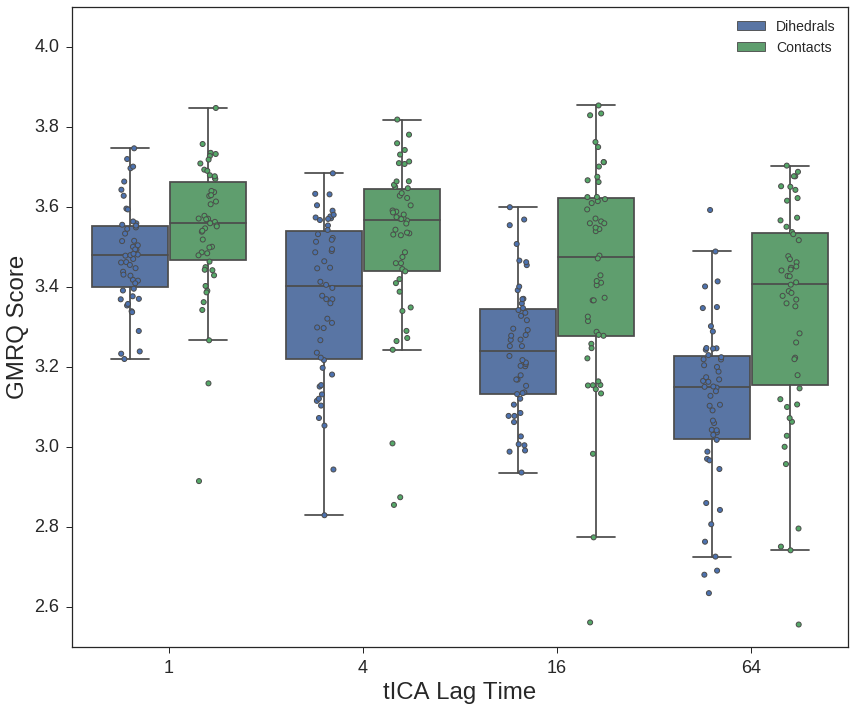

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('ticks')

# Load Data
import pickle
with open('gridscores-%s.pandas.pickl' % date, 'rb') as f:
    df = pickle.load(f)

fig = plt.figure(figsize = (12, 10))

# Stratified Box-and-Whisker Plot
ax = sns.boxplot(x='tica__lag_time', y='score', data=df,
                  hue='featurizer__which_feat')

handles, labels = ax.get_legend_handles_labels()


l = plt.legend(handles[:2], labels[:2], fontsize=14)

plt.xlabel('tICA Lag Time', fontsize=24)
plt.ylabel('GMRQ Score', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tick_params(
    which='both',      # both major and minor ticks are affected
    top='off',         # ticks along the top edge are off
    right='off',       # ticks along the right edge are off
)

plt.ylim((2.5, 4.1))

plt.tight_layout()
plt.savefig("gmrq-%s.pdf" % date)
plt.savefig("gmrq-%s.png" % date, dpi=300)